<a href="https://colab.research.google.com/github/toopidjack/resources/blob/master/Copy_of_Attendee_Intro_to_Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Natural Language Processing
- Throughout this notebook we will be exploring foundational concepts regarding NLP and applying them in a miniature project where we analyze sentiment from hotel reviews.
- Anytime you see a line surrounded by triple asterisks, `***LIKE THIS***`, that is a line of code that you will need to replace or edit.
- Have fun and good luck coding!

### Importing the Packages That We'll Need
One of the things that makes Python **great** for data science is all of the different libraries that exist so we don't have to code them from scratch. Tonight we'll be taking advantage of:
- [Pandas](https://pandas.pydata.org/) for data wrangling and analysis
- [Scikit-learn](https://scikit-learn.org/stable/) for machine learning
- [Regex](https://docs.python.org/3/library/re.html) for regular expression and text parsing

In [0]:
import pandas as pd
import sklearn
import re
%matplotlib inline

## Import the Data Set
Pandas can work with information from all kinds of data sources. Below, we'll import the data we need from a GitHub URL and read it into a Pandas Dataframe.

In [0]:
data = pd.read_csv('https://github.com/Thinkful-Ed/data-201-resources/raw/master/hotel-reviews.csv')
data.head(3)

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN


In [0]:
# Checking the size of our data (rows, columns)
data.shape

(35912, 19)

We don't need to worry about using all of our different columns for this project. Instead, we'll focus just on the test review and ratings columns.

In [0]:
data = data[['name', 'reviews.rating', 'reviews.text']]  ## remove data that we don't care about


Pandas also has some cool funcitonality that let's us quickly edit aspects of our dataframe object like the column names. **Don't forget to make sure those changes persist by using the `inplace` parameter or by overwriting the variable like we did above!**

In [0]:
data.rename(columns={'name':'hotel_name', 'reviews.rating': 'review_rating', 'reviews.text':'review_text'}, inplace=True)

In [0]:
# Check to make sure our changes took effect
data.head(3)

,hotel_name,review_rating,review_text
0,Hotel Russo Palace,4.0,Pleasant 10 min walk along the sea front to th...
1,Hotel Russo Palace,5.0,Really lovely hotel. Stayed on the very top fl...
2,Hotel Russo Palace,5.0,Ett mycket bra hotell. Det som drog ner betyge...


## Data Wrangling / Processing
A major part of every data science project is the data wrangling and processing phase, and this is especially true in NLP. During this section of the notebook, we'll cover:
- How to clean up the clutter from our initial text.
- How to work with variables assignment and Pandas syntax to make sure those changes persist.
- How to use Pandas' `map` functionality to assign more relevant labels to our reviews.

In [0]:
# Make everything lower case — but this doesn't actually change our dataframe!
data['review_text'].str.lower()

0        pleasant 10 min walk along the sea front to th...
1        really lovely hotel. stayed on the very top fl...
2        ett mycket bra hotell. det som drog ner betyge...
3        we stayed here for four nights in october. the...
4        we stayed here for four nights in october. the...
5        we loved staying on the island of lido! you ne...
6        lovely view out onto the lagoon. excellent vie...
7        ottimo soggiorno e ottima sistemazione nei gio...
8        gnstiger ausgangspunkt fr venedig besuche. ruh...
9        lidoen er perfekt til et par dages ro og afsla...
10       accueil chaleureux, en franais changement du l...
11       it was ok hotel is nice from in and out but ro...
12       klasse frhstck, freundliches und aufmerksames ...
13       bardzo sympatyczna obsuga, klimat hotelu. wiet...
14       bra o lugnt lge. stor terrass. nra till den hr...
15       the hotel staff was very friendly and helpful....
16       nice hotel , with very friendly staff and help.

In [0]:
# Make sure that change actually "sticks"
data['review_text'] = data['review_text'].str.lower()

In [0]:
# Remove non-text characters in a similar fashion.
data['review_text'] = data['review_text'].str.replace(r'\.|\!|\?|\'|,|-|\(|\)', "")

In [0]:
# And again fill in blank reviews with '' rather than Null (which would give us errors).
data['review_text'] = data['review_text'].fillna('')

In [0]:
data.head(3)

,hotel_name,review_rating,review_text
0,Hotel Russo Palace,4.0,pleasant 10 min walk along the sea front to th...
1,Hotel Russo Palace,5.0,really lovely hotel stayed on the very top flo...
2,Hotel Russo Palace,5.0,ett mycket bra hotell det som drog ner betyget...


Since we're working on a sentiment analysis project, let's have some fun and change the reviews from numbers to a more emotional human sentiment!

In [0]:
# Taking our hotel ratings and "translating" them to sentiment labels
data['review_sentiment'] = data['review_rating'].map({1.0: "hate",
                                                      2.0: "dislike",
                                                      3.0: "neutral",
                                                      4.0: "like",
                                                      5.0: "love"}, )

After we've done that we can get rid of the old rating column and get rid of any of our rows that are missing a review.

In [0]:
# Dropping that original rating column
data.drop(columns='review_rating', inplace=True)

# Dropping all rows where there is a null value in the sentiment column
data.dropna(subset=['review_sentiment'], inplace=True)

In [0]:
data.head(3)

,hotel_name,review_text,review_sentiment
0,Hotel Russo Palace,pleasant 10 min walk along the sea front to th...,like
1,Hotel Russo Palace,really lovely hotel stayed on the very top flo...,love
2,Hotel Russo Palace,ett mycket bra hotell det som drog ner betyget...,love


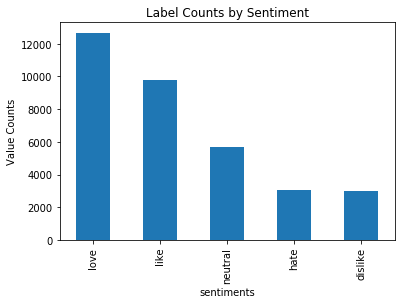

In [0]:
# Quick look at the distribution of our label
import matplotlib.pyplot as plt
# 
data['review_sentiment'].value_counts().plot(kind = 'bar')
plt.title('Label Counts by Sentiment')
plt.xlabel('sentiments')
plt.ylabel('Value Counts');

## Creating a Bag of Words
- In this step, we'll take all of that text that we cleaned up and encode it so our model can understand it.
- Scikit-learn has a number of[ different ways](https://scikit-learn.org/stable/modules/feature_extraction.html) to do this, today we'll stick with the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [0]:
# Import and initiate a vectorizer.
from sklearn.feature_extraction.text import CountVectorizer

# The max features is how many words we want to allow us to create columns for.
vectorizer = CountVectorizer(max_features=5000)

In [0]:
# Vectorize our reviews to transform sentences into columns.
X = vectorizer.fit_transform(data['review_text'])

# And then put all of that in a table.
bag_of_words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [0]:
bag_of_words.head(3)

,00,00am,00pm,10,100,1000,10000,101,1015,10am,10pm,10th,11,110,115,11am,11pm,12,120,125,13,130,14,15,150,1520,16,17,18,19,1am,1st,20,200,2000,2012,2013,2014,2015,2016,...,ya,yard,yards,yeah,year,yearly,years,yelled,yelling,yellow,yellowstone,yes,yet,yo,yogurt,york,yosemite,you,youd,youll,young,younger,your,youre,yourself,youth,youve,yr,yrs,yuck,yummy,zero,zimmer,zion,zona,zone,zoo,zu,zum,zur
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Modeling
Now that we've got everything cleaned up and restructured, it's time to model!
- We'll use our `bag_of_words` as our features to predict our label of `review_sentiment`.
- `X` is a common convention for designating our feature matrix  — the same is true for using `y` for the target series.
- Once we've defined those, we can have our [Multinomial Naive Bayes model](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) learn from them just like we would in many other machine learning problems.

In [0]:
# X is our features or attributes.
X = bag_of_words

# y is our review sentiment column (the outcome we care about).
y = data['review_sentiment']

In [0]:
# Import and instantiate our model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()

# Train our model on the review text and associated labels
trained_model = model.fit(X, y)

## Making Predictions From Our Model
After our model has learned from our historical data, we can introduce new or unseen reviews to it and ask it to predict the sentiment of those.
- Go ahead and play around with the text in your review and see how the output changes!

In [0]:
# Write your own hotel review here...
test_review = ['''
    free breakfast was awesome neighborhood was kinda sketchy lots of bed bugs
    ''']

In [0]:
# Convert the test review just like we did earlier.
X_test = vectorizer.transform(test_review).toarray()

In [0]:
# Use our model to predict a label for it
prediction = trained_model.predict(X_test)
print(prediction)

['like']


In [0]:
# Alternatively, we can predict a probability for each sentiment
probas = trained_model.predict_proba(X_test)[0]

# And convert it to a more readable output.
probabilities = [str(int(x*100))+'%' for x in probas]
labels = list(trained_model.classes_)
dict(zip(probabilities, labels))

{'0%': 'hate', '2%': 'dislike', '23%': 'neutral', '3%': 'love', '69%': 'like'}

# Take Home Challenge
Now that you've been introduced to some of the foundational concepts within the NLP space, we want you to apply what you've learned outside of the workshop environment. We went over the concepts of using "stop words" and "n-grams" to (hopefully) improve your analysis and the accuracy of your model, but didn't actually apply them yet in this workbook.

To do so:
- Try removing stop words from your bag of words structure before feeding it into the Multinomial NB classifier. This can be as simple as including an argument for the `stop_words` parameter in the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) class.
- Additionally, try using bigrams to create some additional context for the text that you're analyzing. Again, scikit-learn makes implementing that change relatively easy by including an `ngram_range` parameter within the same [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) class.
- As you make these changes (and maybe others!), be sure to note how your predictions change accordingly. Do they behave more or less in the ways that you expect?

**Bonus Advanced Challenge:**
Looking to take your modeling powers to the next level? You're going to want a way to see if the predictions that your model is making are accurate or not. In a practical setting, one of the most common ways to do this is by using [train-test-split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
 - You will take a large portion of your data (75% by default using `sklearn`) and train your model or have it learn from all of that information.
 - The other smaller portion (25% in this case) will be held out — your model will **not** learn from these data points. Instead, they can be used to simulate real-world or unseen data points.
 - You will ask your model to make predictions on this smaller set and then compare the predictions made against the actual ground truths to find out how well your model performs.
 - Some common metrics for classification performance are [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) and inspecting the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

### Happy coding and thanks for coming!